### Backtest Results: Analysis and Visualization (v2)

This notebook loads the master results file and performs in-depth analysis and visualization, correctly distinguishing between different strategy parameter sets.

**Workflow:**
1.  **Setup:** Configure paths and define the columns that identify a unique strategy.
2.  **Load Data:** Load the master backtest results file.
3.  **Aggregate Analysis:** Calculate performance metrics by grouping on **unique strategy parameters** to ensure a correct, apples-to-apples comparison.
4.  **Visualize Evolving Sharpe:** Plot the evolving Sharpe ratio for the best-performing strategy run.
5.  **Visualize Equity Curve:** Plot the cumulative return (equity curve) for the best-performing strategy run.

### Setup and Configuration

In [15]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# --- Project Path Setup ---
NOTEBOOK_DIR = Path.cwd()
ROOT_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
SRC_DIR = ROOT_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# --- Local Imports ---
import utils
from config import ANNUAL_RISK_FREE_RATE, TRADING_DAYS_PER_YEAR

# --- Analysis Parameters ---
# ANNUAL_RISK_FREE_RATE = 0.04
# TRADING_DAYS_PER_YEAR = 252
MIN_PERIODS_FOR_SHARPE = 10
BENCHMARK_TICKER = "VGT" # <--- ADD THIS LINE 

# --- !! CRITICAL: Define columns that identify a unique strategy run !! ---
STRATEGY_ID_COLS = [
    'n_select_requested',
    'filter_min_price',
    'filter_min_avg_volume_m',
    'score_weight_rsi', # Add/remove any parameters you tune
]

# --- File Path Construction ---
BACKTEST_DIR = ROOT_DIR / 'output' / 'backtest_results'
SOURCE_PATH = BACKTEST_DIR / 'backtest_master_results.parquet'
DATA_DIR = ROOT_DIR / 'data'

# --- Notebook Setup ---
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1500)
pd.set_option('display.float_format', '{:.4f}'.format)
%load_ext autoreload
%autoreload 2

# --- Verification ---
print(f"Source file for analysis: {SOURCE_PATH}")
print(f"Identifying unique strategies by: {STRATEGY_ID_COLS}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Source file for analysis: c:\Users\ping\Files_win10\python\py311\stocks\output\backtest_results\backtest_master_results.parquet
Identifying unique strategies by: ['n_select_requested', 'filter_min_price', 'filter_min_avg_volume_m', 'score_weight_rsi']


### Step 1: Load Backtest Results

In [16]:
print(f"--- Step 1: Loading data from {SOURCE_PATH.name} ---")

try:
    df_results = pd.read_parquet(SOURCE_PATH)
    # Ensure date column is in datetime format for analysis
    df_results['actual_selection_date_used'] = pd.to_datetime(df_results['actual_selection_date_used'])
    print(f"✅ Successfully loaded and prepared data for {len(df_results)} backtest runs.")
    print(df_results.head(12))
    # display(df_results.head(12))
    # display(df_results.tail())
    # display(df_results)         
except FileNotFoundError:
    print(f"❌ ERROR: Source file not found at {SOURCE_PATH}. Halting execution.")
    df_results = None          

--- Step 1: Loading data from backtest_master_results.parquet ---
✅ Successfully loaded and prepared data for 99 backtest runs.
   actual_selection_date_used  average_return  filter_max_debt_eq  filter_min_avg_volume_m  filter_min_price  filter_min_roe_pct inv_vol_col_name                          log_file  n_select_actual  n_select_requested  num_attempted_trades  num_failed_or_skipped_trades  num_selected_tickers  num_successful_trades  portfolio_return  portfolio_return_normalized       run_timestamp scheme  score_weight_change  score_weight_rel_volume  score_weight_rsi  score_weight_volatility selection_date  sharpe_ratio_period  std_dev_return  total_weight_traded  win_rate
0                  2025-06-11         -0.0178              1.5000                   2.0000           10.0000              5.0000      ATR/Price %  backtest_run_20250616_205128.log               10                  10                    10                             0                    10                     1

### Step 2: Load Price Data

In [17]:
df_prices = pd.read_parquet(DATA_DIR / 'df_adj_close.parquet')
print(f"Loaded price data with {len(df_prices)} rows and {len(df_prices.columns)} columns.")
display(df_prices.head(2))
display(df_prices.tail(2))
print(f'Last 3 rows of benchmark {BENCHMARK_TICKER} prices:')
display(df_prices[BENCHMARK_TICKER].tail(3))

Loaded price data with 343 rows and 1556 columns.


Ticker,A,AA,AAL,AAON,AAPL,ABBV,ABEV,ABNB,ABT,ACGL,ACHR,ACI,ACM,ACN,ACWI,ACWV,ACWX,ADBE,ADC,ADI,ADM,ADP,ADSK,ADT,AEE,AEG,AEM,AEP,AER,AES,AFG,AFL,AFRM,AGCO,AGG,AGI,AGNC,AIG,AIQ,AIRR,AIT,AIZ,AJG,AKAM,AL,ALB,ALC,ALGN,ALK,ALL,ALLE,ALLY,ALNY,ALSN,ALV,AM,AMAT,AMCR,AMD,AME,AMGN,AMH,AMLP,AMP,AMT,AMX,AMZN,AN,ANET,ANSS,AON,AOS,APA,APD,APG,APH,APO,APP,APPF,APTV,AR,ARCC,ARE,ARES,ARGX,ARKB,ARKK,ARM,ARMK,ARW,AS,ASML,ASND,ASR,ASTS,ASX,ATI,ATO,ATR,AU,AUR,AVAV,AVB,AVDE,AVDV,AVEM,AVGO,AVLV,AVTR,AVUS,AVUV,AVY,AWI,AWK,AXON,AXP,AXS,AXTA,AYI,AZEK,AZN,AZO,B,BA,BABA,BAC,BAH,BALL,BAM,BAP,BAX,BBAX,BBCA,BBD,BBEU,BBIN,BBIO,BBJP,BBUS,BBVA,BBWI,BBY,BCE,BCH,BCS,BDX,BEKE,BEN,BEP,BF-A,BF-B,BFAM,BG,BHP,BIDU,BIIB,BIL,BILI,BILS,BINC,BIO,BIP,BIRK,BITB,BIV,BJ,BK,BKLC,BKLN,BKNG,BKR,BLD,BLDR,BLK,BLV,BMI,BMO,BMRN,BMY,BN,BND,BNDX,BNS,BNT,BNTX,BOKF,BOND,BOXX,BP,BPMC,BPOP,BR,BRBR,BRFS,BRK-A,BRK-B,BRKR,BRO,BROS,BRX,BSAC,BSBR,BSCP,BSCQ,BSCR,BSV,BSX,BSY,BTI,BUD,BUFR,BURL,BWA,BWXT,BX,BXP,BXSL,BYD,BZ,C,CACC,CACI,CAE,CAG,CAH,CALF,CARR,CART,CASY,CAT,CAVA,CB,CBOE,CBRE,CBSH,CCCS,CCEP,CCI,CCJ,CCK,CCL,CDE,CDNS,CDP,CDW,CE,CEF,CEG,CELH,CF,CFG,CFLT,CFR,CG,CGCP,CGDV,CGGO,CGGR,CGUS,CGXU,CHD,CHDN,CHE,CHH,CHKP,CHRD,CHRW,CHT,CHTR,CHWY,CI,CIBR,CIEN,CIGI,CINF,CL,CLH,CLS,CLX,CM,CMA,CMCSA,CME,CMF,CMG,CMI,CMS,CNA,CNC,CNH,CNI,CNM,CNP,CNQ,COF,COHR,COIN,COKE,COO,COOP,COP,COR,CORT,COST,COWZ,CP,CPAY,CPB,CPNG,CPRT,CPT,CQP,CR,CRBG,CRDO,CRH,CRK,CRL,CRM,CRS,CRVL,CRWD,CSCO,CSGP,CSL,CSX,CTAS,CTRA,CTSH,CTVA,CUBE,CVE,CVLT,CVNA,CVS,CVX,CW,CWAN,CWB,CWEN,CWEN-A,CWST,CX,CYBR,D,DAL,DASH,DAY,DB,DBEF,DBX,DCI,DD,DDOG,DDS,DE,DECK,DELL,DEO,DFAC,DFAE,DFAI,DFAS,DFAT,DFAU,DFAX,DFCF,DFEM,DFIC,DFIV,DFLV,DFSD,DFSV,DFUS,DFUV,DG,DGRO,DGRW,DGX,DHI,DHR,DIA,DIHP,DINO,DIS,DIVO,DKNG,DKS,DLB,DLN,DLR,DLTR,DOC,DOCS,DOCU,DON,DOV,DOW,DOX,DPZ,DRI,DRS,DSGX,DSI,DT,DTE,DTM,DUHP,DUK,DUOL,DVA,DVN,DVY,DXCM,DXJ,DY,DYNF,E,EA,EAGG,EAT,EBAY,EBR,EC,ECL,ED,EDU,EDV,EEM,EEMV,EFA,EFAV,EFG,EFV,EFX,EG,EGP,EHC,EIX,EL,ELAN,ELF,ELS,ELV,EMA,EMB,EME,EMN,EMR,EMXC,ENB,ENPH,ENSG,ENTG,EOG,EPAM,EPD,EPI,EPRT,EQH,EQIX,EQNR,EQR,EQT,ERIC,ERIE,ERJ,ES,ESAB,ESGD,ESGE,ESGU,ESGV,ESLT,ESNT,ESS,ESTC,ET,ETN,ETR,ETSY,EUFN,EVR,EVRG,EW,EWBC,EWJ,EWT,EWY,EWZ,EXAS,EXC,EXE,EXEL,EXLS,EXP,EXPD,EXPE,EXR,EZU,F,FAF,FANG,FAST,FBCG,FBIN,FBND,FBTC,FCNCA,FCX,FDL,FDN,FDS,FDVV,FDX,FE,FELC,FELG,FER,FERG,FEZ,FFIV,FHN,FI,FICO,FIS,FITB,FIVE,FIX,FIXD,FLEX,FLOT,FLR,FLS,FLUT,FMS,FMX,FN,FND,FNDA,FNDE,FNDF,FNDX,FNF,FNV,FOUR,FOX,FOXA,FPE,FR,FRHC,FRT,FSEC,FSK,FSLR,FSS,FSV,FTAI,FTCS,FTEC,FTI,FTNT,FTS,FTSM,FTV,FUTU,FV,FVD,FWONA,FWONK,FXI,FYBR,G,GAP,GBIL,GBTC,GD,GDDY,GDX,GDXJ,GE,GEHC,GEN,GFI,GFL,GFS,GGAL,GGG,GH,GIB,GIL,GILD,GIS,GL,GLBE,GLD,GLDM,GLPI,GLW,GM,GMAB,GME,GMED,GNRC,GOOG,GOOGL,GOVT,GPC,GPK,GPN,GRAB,GRMN,GS,GSIE,GSK,GSLC,GTLB,GTLS,GUNR,GVI,GWRE,GWW,H,HAL,HALO,HAS,HBAN,HCA,HD,HDB,HDV,HEFA,HEI,HEI-A,HES,HESM,HIG,HII,HIMS,HLI,HLN,HLNE,HLT,HMC,HMY,HOLX,HON,HOOD,HPE,HPQ,HQY,HRB,HRL,HSBC,HSIC,HST,HSY,HTHT,HUBB,HUBS,HUM,HWM,HYD,HYG,HYLB,IAGG,IAU,IBB,IBDR,IBIT,IBKR,IBM,IBN,ICE,ICL,ICLR,ICSH,IDA,IDCC,IDEV,IDV,IDXX,IEF,IEFA,IEI,IEMG,IEUR,IEX,IFF,IGF,IGIB,IGM,IGSB,IGV,IHG,IHI,IJH,IJJ,IJK,IJR,IJS,IJT,ILMN,IMO,INCY,INDA,INFA,INFY,ING,INGR,INSM,INTC,INTU,INVH,IONQ,IOO,IOT,IP,IPG,IQLT,IQV,IR,IRM,ISRG,ISTB,IT,ITA,ITOT,ITT,ITUB,ITW,IUSB,IUSG,IUSV,IVE,IVV,IVW,IVZ,IWB,IWD,IWF,IWM,IWN,IWO,IWP,IWR,IWS,IWV,IWY,IX,IXJ,IXN,IXUS,IYF,IYR,IYW,J,JAAA,JAVA,JAZZ,JBHT,JBL,JBTM,JCI,JCPB,JD,JEF,JEPI,JEPQ,JGRO,JHG,JHMM,JHX,JIRE,JKHY,JLL,JMBS,JMST,JNJ,JNK,JNPR,JOBY,JPIE,JPM,JPST,JQUA,JXN,K,KB,KBR,KBWB,KD,KDP,KEP,KEX,KEY,KEYS,KGC,KHC,KIM,KKR,KLAC,KMB,KMI,KMX,KNG,KNSL,KNTK,KNX,KO,KR,KRC,KRE,KSPI,KT,KTOS,KVUE,KVYO,KWEB,L,LAD,LAMR,LBRDA,LBRDK,LCID,LDOS,LECO,LEGN,LEN,LEVI,LH,LHX,LI,LII,LIN,LKQ,LLY,LLYVA,LLYVK,LMBS,LMT,LNG,LNT,LNW,LOGI,LOPE,LOW,LPLA,LPX,LQD,LRCX,LRN,LSCC,LTH,LULU,LUV,LVS,LW,LYB,LYFT,LYG,LYV,MA,MAA,MANH,MAR,MAS,MASI,MAT,MBB,MBLY,MCD,MCHI,MCHP,MCK,MCO,MDB,MDGL,MDLZ,MDT,MDY,MEDP,MELI,MET,META,MFC,MFG,MGA,MGC,MGK,MGM,MGV,MHK,MIDD,MINT,MKC,MKL,MKSI,MKTX,MLI,MLM,MMC,MMM,MMYT,MNDY,MNST,MO,MOAT,MOG-A,MOH,MORN,MOS,MPC,MPLX,MPWR,M

Ticker,A,AA,AAL,AAON,AAPL,ABBV,ABEV,ABNB,ABT,ACGL,ACHR,ACI,ACM,ACN,ACWI,ACWV,ACWX,ADBE,ADC,ADI,ADM,ADP,ADSK,ADT,AEE,AEG,AEM,AEP,AER,AES,AFG,AFL,AFRM,AGCO,AGG,AGI,AGNC,AIG,AIQ,AIRR,AIT,AIZ,AJG,AKAM,AL,ALB,ALC,ALGN,ALK,ALL,ALLE,ALLY,ALNY,ALSN,ALV,AM,AMAT,AMCR,AMD,AME,AMGN,AMH,AMLP,AMP,AMT,AMX,AMZN,AN,ANET,ANSS,AON,AOS,APA,APD,APG,APH,APO,APP,APPF,APTV,AR,ARCC,ARE,ARES,ARGX,ARKB,ARKK,ARM,ARMK,ARW,AS,ASML,ASND,ASR,ASTS,ASX,ATI,ATO,ATR,AU,AUR,AVAV,AVB,AVDE,AVDV,AVEM,AVGO,AVLV,AVTR,AVUS,AVUV,AVY,AWI,AWK,AXON,AXP,AXS,AXTA,AYI,AZEK,AZN,AZO,B,BA,BABA,BAC,BAH,BALL,BAM,BAP,BAX,BBAX,BBCA,BBD,BBEU,BBIN,BBIO,BBJP,BBUS,BBVA,BBWI,BBY,BCE,BCH,BCS,BDX,BEKE,BEN,BEP,BF-A,BF-B,BFAM,BG,BHP,BIDU,BIIB,BIL,BILI,BILS,BINC,BIO,BIP,BIRK,BITB,BIV,BJ,BK,BKLC,BKLN,BKNG,BKR,BLD,BLDR,BLK,BLV,BMI,BMO,BMRN,BMY,BN,BND,BNDX,BNS,BNT,BNTX,BOKF,BOND,BOXX,BP,BPMC,BPOP,BR,BRBR,BRFS,BRK-A,BRK-B,BRKR,BRO,BROS,BRX,BSAC,BSBR,BSCP,BSCQ,BSCR,BSV,BSX,BSY,BTI,BUD,BUFR,BURL,BWA,BWXT,BX,BXP,BXSL,BYD,BZ,C,CACC,CACI,CAE,CAG,CAH,CALF,CARR,CART,CASY,CAT,CAVA,CB,CBOE,CBRE,CBSH,CCCS,CCEP,CCI,CCJ,CCK,CCL,CDE,CDNS,CDP,CDW,CE,CEF,CEG,CELH,CF,CFG,CFLT,CFR,CG,CGCP,CGDV,CGGO,CGGR,CGUS,CGXU,CHD,CHDN,CHE,CHH,CHKP,CHRD,CHRW,CHT,CHTR,CHWY,CI,CIBR,CIEN,CIGI,CINF,CL,CLH,CLS,CLX,CM,CMA,CMCSA,CME,CMF,CMG,CMI,CMS,CNA,CNC,CNH,CNI,CNM,CNP,CNQ,COF,COHR,COIN,COKE,COO,COOP,COP,COR,CORT,COST,COWZ,CP,CPAY,CPB,CPNG,CPRT,CPT,CQP,CR,CRBG,CRDO,CRH,CRK,CRL,CRM,CRS,CRVL,CRWD,CSCO,CSGP,CSL,CSX,CTAS,CTRA,CTSH,CTVA,CUBE,CVE,CVLT,CVNA,CVS,CVX,CW,CWAN,CWB,CWEN,CWEN-A,CWST,CX,CYBR,D,DAL,DASH,DAY,DB,DBEF,DBX,DCI,DD,DDOG,DDS,DE,DECK,DELL,DEO,DFAC,DFAE,DFAI,DFAS,DFAT,DFAU,DFAX,DFCF,DFEM,DFIC,DFIV,DFLV,DFSD,DFSV,DFUS,DFUV,DG,DGRO,DGRW,DGX,DHI,DHR,DIA,DIHP,DINO,DIS,DIVO,DKNG,DKS,DLB,DLN,DLR,DLTR,DOC,DOCS,DOCU,DON,DOV,DOW,DOX,DPZ,DRI,DRS,DSGX,DSI,DT,DTE,DTM,DUHP,DUK,DUOL,DVA,DVN,DVY,DXCM,DXJ,DY,DYNF,E,EA,EAGG,EAT,EBAY,EBR,EC,ECL,ED,EDU,EDV,EEM,EEMV,EFA,EFAV,EFG,EFV,EFX,EG,EGP,EHC,EIX,EL,ELAN,ELF,ELS,ELV,EMA,EMB,EME,EMN,EMR,EMXC,ENB,ENPH,ENSG,ENTG,EOG,EPAM,EPD,EPI,EPRT,EQH,EQIX,EQNR,EQR,EQT,ERIC,ERIE,ERJ,ES,ESAB,ESGD,ESGE,ESGU,ESGV,ESLT,ESNT,ESS,ESTC,ET,ETN,ETR,ETSY,EUFN,EVR,EVRG,EW,EWBC,EWJ,EWT,EWY,EWZ,EXAS,EXC,EXE,EXEL,EXLS,EXP,EXPD,EXPE,EXR,EZU,F,FAF,FANG,FAST,FBCG,FBIN,FBND,FBTC,FCNCA,FCX,FDL,FDN,FDS,FDVV,FDX,FE,FELC,FELG,FER,FERG,FEZ,FFIV,FHN,FI,FICO,FIS,FITB,FIVE,FIX,FIXD,FLEX,FLOT,FLR,FLS,FLUT,FMS,FMX,FN,FND,FNDA,FNDE,FNDF,FNDX,FNF,FNV,FOUR,FOX,FOXA,FPE,FR,FRHC,FRT,FSEC,FSK,FSLR,FSS,FSV,FTAI,FTCS,FTEC,FTI,FTNT,FTS,FTSM,FTV,FUTU,FV,FVD,FWONA,FWONK,FXI,FYBR,G,GAP,GBIL,GBTC,GD,GDDY,GDX,GDXJ,GE,GEHC,GEN,GFI,GFL,GFS,GGAL,GGG,GH,GIB,GIL,GILD,GIS,GL,GLBE,GLD,GLDM,GLPI,GLW,GM,GMAB,GME,GMED,GNRC,GOOG,GOOGL,GOVT,GPC,GPK,GPN,GRAB,GRMN,GS,GSIE,GSK,GSLC,GTLB,GTLS,GUNR,GVI,GWRE,GWW,H,HAL,HALO,HAS,HBAN,HCA,HD,HDB,HDV,HEFA,HEI,HEI-A,HES,HESM,HIG,HII,HIMS,HLI,HLN,HLNE,HLT,HMC,HMY,HOLX,HON,HOOD,HPE,HPQ,HQY,HRB,HRL,HSBC,HSIC,HST,HSY,HTHT,HUBB,HUBS,HUM,HWM,HYD,HYG,HYLB,IAGG,IAU,IBB,IBDR,IBIT,IBKR,IBM,IBN,ICE,ICL,ICLR,ICSH,IDA,IDCC,IDEV,IDV,IDXX,IEF,IEFA,IEI,IEMG,IEUR,IEX,IFF,IGF,IGIB,IGM,IGSB,IGV,IHG,IHI,IJH,IJJ,IJK,IJR,IJS,IJT,ILMN,IMO,INCY,INDA,INFA,INFY,ING,INGR,INSM,INTC,INTU,INVH,IONQ,IOO,IOT,IP,IPG,IQLT,IQV,IR,IRM,ISRG,ISTB,IT,ITA,ITOT,ITT,ITUB,ITW,IUSB,IUSG,IUSV,IVE,IVV,IVW,IVZ,IWB,IWD,IWF,IWM,IWN,IWO,IWP,IWR,IWS,IWV,IWY,IX,IXJ,IXN,IXUS,IYF,IYR,IYW,J,JAAA,JAVA,JAZZ,JBHT,JBL,JBTM,JCI,JCPB,JD,JEF,JEPI,JEPQ,JGRO,JHG,JHMM,JHX,JIRE,JKHY,JLL,JMBS,JMST,JNJ,JNK,JNPR,JOBY,JPIE,JPM,JPST,JQUA,JXN,K,KB,KBR,KBWB,KD,KDP,KEP,KEX,KEY,KEYS,KGC,KHC,KIM,KKR,KLAC,KMB,KMI,KMX,KNG,KNSL,KNTK,KNX,KO,KR,KRC,KRE,KSPI,KT,KTOS,KVUE,KVYO,KWEB,L,LAD,LAMR,LBRDA,LBRDK,LCID,LDOS,LECO,LEGN,LEN,LEVI,LH,LHX,LI,LII,LIN,LKQ,LLY,LLYVA,LLYVK,LMBS,LMT,LNG,LNT,LNW,LOGI,LOPE,LOW,LPLA,LPX,LQD,LRCX,LRN,LSCC,LTH,LULU,LUV,LVS,LW,LYB,LYFT,LYG,LYV,MA,MAA,MANH,MAR,MAS,MASI,MAT,MBB,MBLY,MCD,MCHI,MCHP,MCK,MCO,MDB,MDGL,MDLZ,MDT,MDY,MEDP,MELI,MET,META,MFC,MFG,MGA,MGC,MGK,MGM,MGV,MHK,MIDD,MINT,MKC,MKL,MKSI,MKTX,MLI,MLM,MMC,MMM,MMYT,MNDY,MNST,MO,MOAT,MOG-A,MOH,MORN,MOS,MPC,MPLX,MPWR,M

Last 3 rows of benchmark VGT prices:


Date
2025-06-11   629.2700
2025-06-12   633.7900
2025-06-13   623.2900
Name: VGT, dtype: float64

### Step 3: Aggregate Performance Analysis

In [18]:
if df_results is not None and df_prices is not None:
    print("\n--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle & vs. Benchmark) ---")
    
    # --- Part A: Calculate Benchmark Performance First ---
    print(f"Calculating benchmark performance for '{BENCHMARK_TICKER}'...")
    
    # Get the full date range of our entire backtest period
    min_date = df_results['actual_selection_date_used'].min()
    max_date = df_results['actual_selection_date_used'].max() + pd.DateOffset(days=2)
    benchmark_full_range = pd.date_range(start=min_date, end=max_date, freq='B')
    
    # Benchmark 1: Buy and Hold (100% invested)
    benchmark_returns_100 = df_prices[BENCHMARK_TICKER].pct_change().reindex(benchmark_full_range).fillna(0)
    mean_bench_100 = benchmark_returns_100.mean()
    std_bench_100 = benchmark_returns_100.std()
    benchmark_buy_and_hold_sharpe = (mean_bench_100 * TRADING_DAYS_PER_YEAR - ANNUAL_RISK_FREE_RATE) / (std_bench_100 * np.sqrt(TRADING_DAYS_PER_YEAR))

    # --- FIX STARTS HERE ---
    # Benchmark 2: Timed (50% cash, mimicking the strategy)
    # First, get only the UNIQUE selection dates to avoid duplicate index issues.
    unique_selection_dates = df_results['actual_selection_date_used'].unique()
    
    selection_indices = df_prices.index.get_indexer(unique_selection_dates, method='ffill')
    buy_prices_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 1]
    sell_prices_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 2]
    trade_returns_bench = (sell_prices_bench.values - buy_prices_bench.values) / buy_prices_bench.values
    
    sell_dates_bench = df_prices.index[selection_indices + 2]
    timed_benchmark_series = pd.Series(trade_returns_bench, index=sell_dates_bench).reindex(benchmark_full_range).fillna(0)
    # --- FIX ENDS HERE ---

    mean_bench_50 = timed_benchmark_series.mean()
    std_bench_50 = timed_benchmark_series.std()
    benchmark_timed_sharpe = (mean_bench_50 * TRADING_DAYS_PER_YEAR - ANNUAL_RISK_FREE_RATE) / (std_bench_50 * np.sqrt(TRADING_DAYS_PER_YEAR))


    # --- Part B: Calculate Strategy Performance (Corrected Logic) ---
    summary_records = []
    grouped = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    daily_risk_free_rate = ANNUAL_RISK_FREE_RATE / TRADING_DAYS_PER_YEAR

    print("Analyzing each unique strategy run...")
    for group_name, group_df in grouped:
        
        # --- Correctly find the T+2 TRADING DAY for the sell date ---
        selection_indices_strat = df_prices.index.get_indexer(group_df['actual_selection_date_used'], method='ffill')
        sell_dates_strat = df_prices.index[selection_indices_strat + 2]
        
        trade_returns = pd.Series(group_df['portfolio_return'].values, index=sell_dates_strat)

        # Create the continuous timeline with zero-fill for cash days
        start_date = trade_returns.index.min()
        end_date = trade_returns.index.max()
        full_date_range = pd.date_range(start=start_date, end=end_date, freq='B')
        daily_return_series = trade_returns.reindex(full_date_range).fillna(0)
        
        mean_return = daily_return_series.mean()
        std_dev_return = daily_return_series.std()
        
        if std_dev_return > 1e-9:
            sharpe_ratio = (mean_return - daily_risk_free_rate) / std_dev_return
        else:
            sharpe_ratio = np.nan
        annualized_sharpe = sharpe_ratio * np.sqrt(TRADING_DAYS_PER_YEAR)
        
        record = dict(zip(STRATEGY_ID_COLS + ['scheme'], group_name))
        record['Num Trade Days'] = len(group_df)
        record['Annualized Sharpe (adj. for cash)'] = annualized_sharpe
        summary_records.append(record)

    # --- Part C: Combine and Display Final Summary ---
    df_summary = pd.DataFrame(summary_records).set_index(STRATEGY_ID_COLS + ['scheme'])
    df_summary = df_summary.sort_values(by='Annualized Sharpe (adj. for cash)', ascending=False)
    
    # Create benchmark DataFrame to append
    benchmark_data = {
        'Num Trade Days': ['N/A', 'N/A'],
        'Annualized Sharpe (adj. for cash)': [benchmark_buy_and_hold_sharpe, benchmark_timed_sharpe]
    }
    # Adjusting the benchmark index to match the columns in df_summary
    # We create a list of tuples for the MultiIndex
    benchmark_index_tuples = [
        tuple(['BENCHMARK', BENCHMARK_TICKER, 'Buy & Hold'] + ['N/A'] * (len(df_summary.index.names) - 3)),
        tuple(['BENCHMARK', BENCHMARK_TICKER, 'Timed'] + ['N/A'] * (len(df_summary.index.names) - 3))
    ]
    benchmark_index = pd.MultiIndex.from_tuples(benchmark_index_tuples, names=df_summary.index.names)
    df_benchmark = pd.DataFrame(benchmark_data, index=benchmark_index)

    df_final_summary = pd.concat([df_summary, df_benchmark])

    print(f"\nAnalysis complete. Comparison vs. '{BENCHMARK_TICKER}'")
    display(df_final_summary)

else:
    print("Skipping analysis because data or price files failed to load.")


--- Step 2: Aggregate Performance Analysis (Corrected for 2-Day Cycle & vs. Benchmark) ---
Calculating benchmark performance for 'VGT'...
Analyzing each unique strategy run...

Analysis complete. Comparison vs. 'VGT'


Num Trade Days  Annualized Sharpe (adj. for cash)
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                                                  
10                 10.0000          2.0000                  0.3500           IV                 33                             3.1716
                                                                             EW                 33                             2.7419
                                                                             SW                 33                             1.8287
BENCHMARK           VGT              Buy & Hold              N/A             N/A               N/A                             5.1305
                                     Timed                   N/A             N/A               N/A                             4.7141

In [19]:
# This cell demonstrates the CORRECTED DateOffset logic and adds a clear benchmark comparison.

if 'df_results' in locals() and 'df_prices' in locals():
    
    # --- 1. Isolate a small sample to demonstrate with ---
    grouped_for_demo = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    group_name, sample_group_df = next(iter(grouped_for_demo)) # Get the first group
    
    print(f"--- Demonstrating with a sample group: {group_name} ---")
    
    # --- 2. Get the integer positions of the selection dates ---
    selection_dates = sample_group_df['actual_selection_date_used']
    selection_indices = df_prices.index.get_indexer(selection_dates, method='ffill')
    
    # --- 3. Calculate Benchmark Return for the exact T+1 to T+2 period ---
    buy_prices_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 1]
    sell_prices_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 2]
    benchmark_trade_returns = (sell_prices_bench.values - buy_prices_bench.values) / buy_prices_bench.values

    # --- 4. Create the comprehensive demonstration DataFrame with clearer column names ---
    demo_df = pd.DataFrame({
        'A_Selection_Date': selection_dates.values,
        'B_Correct_Buy_Date (T+1)': df_prices.index[selection_indices + 1],
        'C_Correct_Sell_Date (T+2)': df_prices.index[selection_indices + 2],
        'D_Portfolio_Return': sample_group_df['portfolio_return'].values,
        'E_Benchmark_Return (for same T+1->T+2 period)': benchmark_trade_returns
    }).head() # Show the first 5 rows for clarity
    
    print("\n--- Side-by-Side Performance for Individual Trades ---")
    display(demo_df)
    
    print("\nEXPLANATION:")
    print(" - This table shows an apples-to-apples comparison for each individual trade cycle.")
    print(" - Column 'D' is your strategy's return from the close of the Buy Date to the close of the Sell Date.")
    print(f" - Column 'E' is the benchmark's return for that EXACT SAME one-day holding period.")
    print(f" - Therefore, Column 'E' IS the '100% holding' benchmark return for the specific duration of the trade.")

else:
    print("Please run the data loading cells first.")

--- Demonstrating with a sample group: (10, 10.0, 2.0, 0.35, 'EW') ---

--- Side-by-Side Performance for Individual Trades ---


,A_Selection_Date,B_Correct_Buy_Date (T+1),C_Correct_Sell_Date (T+2),D_Portfolio_Return,E_Benchmark_Return (for same T+1->T+2 period)
0,2025-06-11,2025-06-12,2025-06-13,-0.0178,-0.0166
1,2025-06-10,2025-06-11,2025-06-12,-0.0016,0.0072
2,2025-06-09,2025-06-10,2025-06-11,-0.0033,-0.0040
3,2025-06-06,2025-06-09,2025-06-10,-0.0036,0.0042
4,2025-06-05,2025-06-06,2025-06-09,0.0027,0.0043



EXPLANATION:
 - This table shows an apples-to-apples comparison for each individual trade cycle.
 - Column 'D' is your strategy's return from the close of the Buy Date to the close of the Sell Date.
 - Column 'E' is the benchmark's return for that EXACT SAME one-day holding period.
 - Therefore, Column 'E' IS the '100% holding' benchmark return for the specific duration of the trade.


In [20]:
# This cell demonstrates the CORRECTED DateOffset logic and adds a benchmark comparison.

if 'df_results' in locals() and 'df_prices' in locals():
    
    # --- 1. Isolate a small sample to demonstrate with ---
    grouped_for_demo = df_results.groupby(STRATEGY_ID_COLS + ['scheme'])
    group_name, sample_group_df = next(iter(grouped_for_demo)) # Get the first group
    
    print(f"--- Demonstrating with a sample group: {group_name} ---")
    
    # --- 2. Get the integer positions of the selection dates ---
    selection_dates = sample_group_df['actual_selection_date_used']
    selection_indices = df_prices.index.get_indexer(selection_dates, method='ffill')
    
    # --- 3. Calculate Benchmark Return for the exact T+1 to T+2 period ---
    buy_prices_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 1]
    sell_prices_bench = df_prices[BENCHMARK_TICKER].iloc[selection_indices + 2]
    benchmark_trade_returns = (sell_prices_bench.values - buy_prices_bench.values) / buy_prices_bench.values

    # --- 4. Create the comprehensive "before and after" DataFrame ---
    demo_df = pd.DataFrame({
        'A_Selection_Date': selection_dates.values,
        'B_Incorrect_Sell_Date (Calendar)': (selection_dates + pd.DateOffset(days=2)).values,
        'C_Correct_Sell_Date (Trading)': df_prices.index[selection_indices + 2],
        'D_Portfolio_Return': sample_group_df['portfolio_return'].values,
        'E_Benchmark_Return': benchmark_trade_returns
    }).head() # Show the first 5 rows for clarity
    
    print("\n--- Side-by-Side Performance for Individual Trades ---")
    display(demo_df)
    
    print("\nEXPLANATION:")
    print(" - Column 'C' shows the correct sell date, skipping weekends (e.g., from 2025-06-06 to 2025-06-10).")
    print(" - Column 'D' is your strategy's return for the C-B period (T+1 close to T+2 close).")
    print(f" - Column 'E' is the '{BENCHMARK_TICKER}' return for the exact same period, allowing for a direct comparison.")

else:
    print("Please run the data loading cells first.")

--- Demonstrating with a sample group: (10, 10.0, 2.0, 0.35, 'EW') ---

--- Side-by-Side Performance for Individual Trades ---


,A_Selection_Date,B_Incorrect_Sell_Date (Calendar),C_Correct_Sell_Date (Trading),D_Portfolio_Return,E_Benchmark_Return
0,2025-06-11,2025-06-13,2025-06-13,-0.0178,-0.0166
1,2025-06-10,2025-06-12,2025-06-12,-0.0016,0.0072
2,2025-06-09,2025-06-11,2025-06-11,-0.0033,-0.0040
3,2025-06-06,2025-06-08,2025-06-10,-0.0036,0.0042
4,2025-06-05,2025-06-07,2025-06-09,0.0027,0.0043



EXPLANATION:
 - Column 'C' shows the correct sell date, skipping weekends (e.g., from 2025-06-06 to 2025-06-10).
 - Column 'D' is your strategy's return for the C-B period (T+1 close to T+2 close).
 - Column 'E' is the 'VGT' return for the exact same period, allowing for a direct comparison.


In [21]:
# This interactive cell allows the user to select and plot the equity curves
# for any combination of strategy runs against the benchmark.

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

if 'df_summary' in locals() and not df_summary.empty and 'df_prices' in locals():

    # --- 1. Prepare the list of strategies for the widget ---
    # We need a user-friendly name for each strategy and a way to map it back
    # to the MultiIndex tuple used for filtering.
    strategy_map = {}
    for strategy_params in df_summary.index:
        params_dict = dict(zip(df_summary.index.names, strategy_params))
        # Create a concise, readable label
        params_list = [f"{k.split('_')[-1]}={v}" for k, v in params_dict.items() if k not in ['scheme', 'n_select_requested']]
        label_params = f"n={params_dict.get('n_select_requested', 'N/A')}, {', '.join(params_list)}"
        strategy_label = f"#{len(strategy_map)+1} - Scheme: {params_dict['scheme']} ({label_params})"
        strategy_map[strategy_label] = strategy_params

    # --- 2. Create the Interactive Selection Widget ---
    strategy_selector = widgets.SelectMultiple(
        options=strategy_map.keys(),
        value=[list(strategy_map.keys())[0]],  # Default to selecting the top strategy
        description='Strategies',
        disabled=False,
        layout={'height': '250px', 'width': '95%'} # Make the widget easy to use
    )

    # --- 3. Create the function that will be called by the widget ---
    def plot_selected_strategies(selected_labels):
        if not selected_labels:
            print("Please select at least one strategy to plot.")
            return

        print(f"Plotting {len(selected_labels)} selected strategies vs. Benchmark...")

        # --- Determine the overall date range for the plot ---
        selected_indices = [strategy_map[label] for label in selected_labels]
        all_relevant_runs = df_results[df_results.set_index(df_summary.index.names).index.isin(selected_indices)]
        
        if all_relevant_runs.empty:
            print("No data found for the selected strategies.")
            return
            
        first_selection_date = all_relevant_runs['actual_selection_date_used'].min()
        last_selection_date = all_relevant_runs['actual_selection_date_used'].max()
        
        start_loc = df_prices.index.get_indexer([first_selection_date], method='ffill')[0] + 1
        end_loc = df_prices.index.get_indexer([last_selection_date], method='ffill')[0] + 2
        
        correct_date_range = df_prices.loc[df_prices.index[start_loc]:df_prices.index[end_loc]].index

        # --- Setup the Plot ---
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # --- Loop Through Selected Strategies, Calculate, and Plot ---
        for label in selected_labels:
            strategy_params = strategy_map[label]
            
            mask = (df_results[df_summary.index.names] == strategy_params).all(axis=1)
            df_strategy = df_results[mask]
            
            selection_indices = df_prices.index.get_indexer(df_strategy['actual_selection_date_used'], method='ffill')
            sell_dates = df_prices.index[selection_indices + 2]
            trade_returns = pd.Series(df_strategy['portfolio_return'].values, index=sell_dates)
            strategy_daily_returns = trade_returns.reindex(correct_date_range).fillna(0)
            strategy_equity_curve = (1 + strategy_daily_returns).cumprod()

            ax.plot(strategy_equity_curve.index, strategy_equity_curve.values, 
                    label=label, linewidth=2.0)

        # --- Plot the Benchmark Curve ---
        benchmark_prices = df_prices.loc[correct_date_range, BENCHMARK_TICKER]
        benchmark_equity_curve = benchmark_prices / benchmark_prices.iloc[0]
        ax.plot(benchmark_equity_curve.index, benchmark_equity_curve.values, 
                label=f"Buy & Hold '{BENCHMARK_TICKER}'", linewidth=1.5, color='black', linestyle='--', zorder=1)
        
        # --- Finalize the Plot ---
        ax.set_title(f"Selected Strategies vs. Benchmark: Growth of $1", fontsize=16)
        ax.set_xlabel("Date")
        ax.set_ylabel("Equity Curve (1 = breakeven)")
        ax.legend(fontsize=9, loc='upper left')
        ax.grid(True, which='both', linestyle=':', linewidth=0.6)
        fig.autofmt_xdate()
        
        plt.show()

    # --- 4. Display the widget and link it to the plotting function ---
    print("✅ Interactive Plotting Cell Ready")
    print("Use Ctrl+Click (or Cmd+Click on Mac) to select multiple strategies, or Shift+Click for a range.")
    
    widgets.interact(plot_selected_strategies, selected_labels=strategy_selector)

else:
    print("Please run the analysis in 'Step 2' first to generate the 'df_summary' table.")

✅ Interactive Plotting Cell Ready
Use Ctrl+Click (or Cmd+Click on Mac) to select multiple strategies, or Shift+Click for a range.


interactive(children=(SelectMultiple(description='Strategies', index=(0,), layout=Layout(height='250px', width…

In [22]:
# Select the 'portfolio_return' column FIRST, then apply aggregations
df_summary = grouped['portfolio_return'].agg(['mean', 'std', 'count']).sort_values(by='mean', ascending=False)

print("Aggregate statistics for each unique strategy run:")
display(df_summary)

Aggregate statistics for each unique strategy run:


mean    std  count
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                     
10                 10.0000          2.0000                  0.3500           IV     0.0026 0.0120     33
                                                                             EW     0.0025 0.0134     33
                                                                             SW     0.0020 0.0153     33

In [23]:
# Tell the aggregation functions to automatically ignore non-numeric columns
df_summary_all_numeric = grouped.agg(
    mean=('portfolio_return', lambda x: x.mean(numeric_only=True)),
    std=('portfolio_return', lambda x: x.std(numeric_only=True)),
    count=('portfolio_return', 'count')
).sort_values(by='mean', ascending=False)


# A simpler way if you just want to run the functions on all applicable columns
df_summary_all_numeric = grouped.mean(numeric_only=True)

print("Mean of all numeric columns for each unique strategy run:")
display(df_summary_all_numeric)

Mean of all numeric columns for each unique strategy run:


average_return  filter_max_debt_eq  filter_min_roe_pct  n_select_actual  num_attempted_trades  num_failed_or_skipped_trades  num_selected_tickers  num_successful_trades  portfolio_return  portfolio_return_normalized  score_weight_change  score_weight_rel_volume  score_weight_volatility  sharpe_ratio_period  std_dev_return  total_weight_traded  win_rate
n_select_requested filter_min_price filter_min_avg_volume_m score_weight_rsi scheme                                                                                                                                                                                                                                                                                                                                                                    
10                 10.0000          2.0000                  0.3500           EW              0.0025              1.5000              5.0000          10.0000                9.9697                        0.0303               10.0000                 9.9697            0.0025                       0.0025               0.3500                   0.2000                   0.1000               0.1059          0.0196               0.9970    0.5286
                                                                             IV              0.0025              1.5000              5.0000          10.0000                9.9697                        0.0303               10.0000                 9.9697            0.0026                       0.0026               0.3500                   0.2000                   0.1000               0.1059          0.0196               0.9967    0.5286
                                                                             SW              0.0025              1.5000              5.0000          10.0000                9.9697                        0.0303               10.0000                 9.9697            0.0020                       0.0019               0.3500                   0.2000                   0.1000               0.1059          0.0196               0.9955    0.5286

### Step 3: Visualize Evolving Sharpe for Top Strategy


--- Step 3: Plotting Evolving Sharpe Ratio for the Top Strategy Run ---


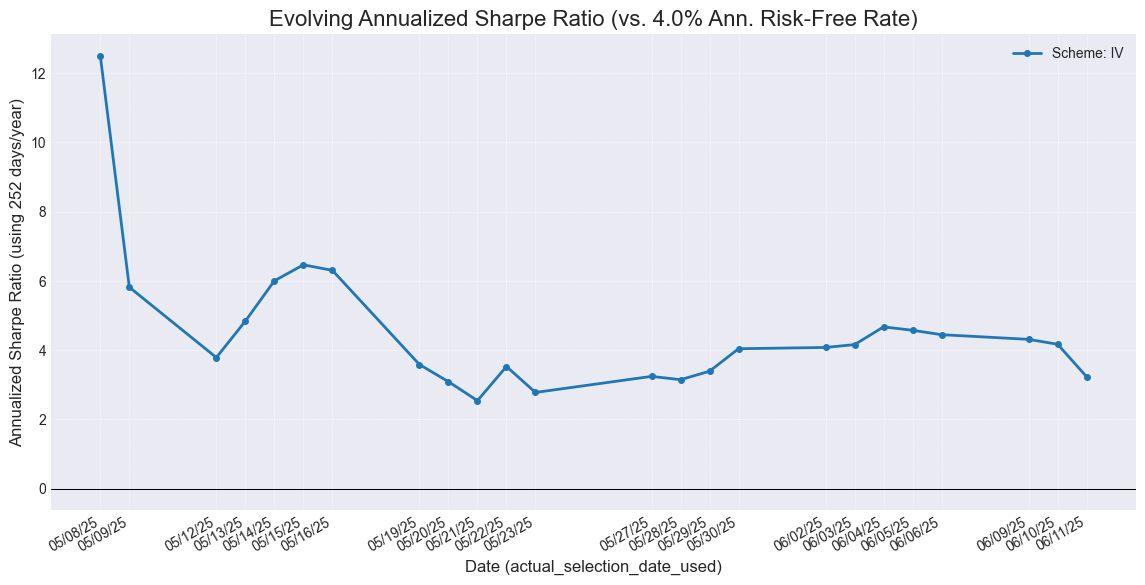

In [24]:
if 'df_summary' in locals() and not df_summary.empty:
    print("\n--- Step 3: Plotting Evolving Sharpe Ratio for the Top Strategy Run ---")
    
    # Get the parameters of the best strategy from our summary table
    top_strategy_params = df_summary.index[0]
    
    # Create a filter mask to select only the data for this specific run
    strategy_filter_mask = (df_results[STRATEGY_ID_COLS + ['scheme']] == top_strategy_params).all(axis=1)
    df_top_strategy = df_results[strategy_filter_mask]

    # Call the utility function
    utils.plot_evolving_annualized_sharpe(
        df=df_top_strategy, # Pass only the filtered data for the best strategy
        date_col='actual_selection_date_used',
        return_col='portfolio_return',
        scheme_col='scheme',
        annual_risk_free_rate=ANNUAL_RISK_FREE_RATE,
        trading_days_per_year=TRADING_DAYS_PER_YEAR,
        min_periods_for_sharpe=MIN_PERIODS_FOR_SHARPE
    )
else:
    print("Skipping visualization.")

### Below Cells are for Analysis

In [29]:
# See the names of all the groups pandas created
print("Available group names:")
print(list(grouped.groups.keys())[0:5]) # Print the first 5 group names
print(list(grouped.groups.values())[0:5]) # Print the first 5 group names


# Now, pick one of those names to inspect
# The name will be a tuple, e.g., (10, 10.0, 2.0, 0.35, 'EW')
a_specific_group_name = list(grouped.groups.keys())[0] 

print(f"\n--- Data for the specific group: {a_specific_group_name} ---")
display(grouped.get_group(a_specific_group_name))

Available group names:
[(10, 10.0, 2.0, 0.35, 'EW'), (10, 10.0, 2.0, 0.35, 'IV'), (10, 10.0, 2.0, 0.35, 'SW')]
[Index([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96], dtype='int64'), Index([1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67, 70, 73, 76, 79, 82, 85, 88, 91, 94, 97], dtype='int64'), Index([2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89, 92, 95, 98], dtype='int64')]

--- Data for the specific group: (10, 10.0, 2.0, 0.35, 'EW') ---


,actual_selection_date_used,average_return,filter_max_debt_eq,filter_min_avg_volume_m,filter_min_price,filter_min_roe_pct,inv_vol_col_name,log_file,n_select_actual,n_select_requested,num_attempted_trades,num_failed_or_skipped_trades,num_selected_tickers,num_successful_trades,portfolio_return,portfolio_return_normalized,run_timestamp,scheme,score_weight_change,score_weight_rel_volume,score_weight_rsi,score_weight_volatility,selection_date,sharpe_ratio_period,std_dev_return,total_weight_traded,win_rate
0,2025-06-11,-0.0178,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0178,-0.0178,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-11,-0.7959,0.0226,1.0000,0.2000
3,2025-06-10,-0.0016,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0016,-0.0016,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-10,-0.1175,0.0152,1.0000,0.4000
6,2025-06-09,-0.0033,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0033,-0.0033,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-09,-0.2777,0.0123,1.0000,0.5000
9,2025-06-06,-0.0036,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,-0.0036,-0.0036,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-06,-0.3225,0.0116,1.0000,0.5000
12,2025-06-05,0.0027,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,0.0027,0.0027,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-05,0.1140,0.0224,1.0000,0.6000
15,2025-06-04,0.0143,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,0.0143,0.0143,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-04,1.3737,0.0103,1.0000,0.9000
18,2025-06-03,0.0041,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,0.0041,0.0041,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-03,0.1870,0.0213,1.0000,0.4000
21,2025-06-02,0.0035,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,0.0035,0.0035,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-06-02,0.2505,0.0132,1.0000,0.5000
24,2025-05-30,0.0184,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,0.0184,0.0184,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-05-30,1.0101,0.0180,1.0000,0.8000
27,2025-05-29,0.0073,1.5000,2.0000,10.0000,5.0000,ATR/Price %,backtest_run_20250616_205128.log,10,10,10,0,10,10,0.0073,0.0073,2025-06-16 20:51:28,EW,0.3500,0.2000,0.3500,0.1000,2025-05-29,0.4040,0.0178,1.0000,0.5000
